In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import shap
import joblib
import tensorflow as tf
import matplotlib.pyplot as plt
import joblib
from sklearn.preprocessing import StandardScaler

# 1. SHAP analysis

In [3]:
# Import training and testing sets
X_train = pd.read_csv("/home/s2106664/msc_project/training_testing_dataset/X_train.csv")
X_validate = pd.read_csv("/home/s2106664/msc_project/training_testing_dataset/X_validate.csv")
X_test = pd.read_csv("/home/s2106664/msc_project/training_testing_dataset/X_test.csv")
y_train = pd.read_csv("/home/s2106664/msc_project/training_testing_dataset/y_train.csv").squeeze()
y_validate = pd.read_csv("/home/s2106664/msc_project/training_testing_dataset/y_validate.csv").squeeze()
y_test = pd.read_csv("/home/s2106664/msc_project/training_testing_dataset/y_test.csv").squeeze()

In [4]:
# Load scaler
scaler = joblib.load("/home/s2106664/msc_project/model_training/MLP_sigmoid/scaler.pkl")

# Features to scale (same as training)
scaled_features = ["hypermutation_rate", "cdr3_length", "Factor_I", "Factor_II",
                   "Factor_III", "Factor_IV", "Factor_V", "np1_length", "np2_length"]

X_test_scaled = X_test.copy()
X_test_scaled[scaled_features] = scaler.transform(X_test_scaled[scaled_features])

# Convert to tensor
X_test_tensor = torch.tensor(X_test_scaled.values, dtype=torch.float32)


X_train_scaled = X_train.copy()
X_train_scaled[scaled_features] = scaler.transform(X_train_scaled[scaled_features])

# Convert to tensor
X_train_tensor = torch.tensor(X_train_scaled.values, dtype=torch.float32)




class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(512, 512),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(512, 256),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(256, 512),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(512, 1)
        )

    def forward(self, x):
        return self.net(x)

# Load model
input_dim = X_test_tensor.shape[1]
model = MLP(input_dim=input_dim)
model.load_state_dict(torch.load("/home/s2106664/msc_project/model_training/MLP_sigmoid/best_mlp_sigmoid_model.pth"))
model.eval()

/home/s2106664/.conda/envs/mscproject/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


MLP(
  (net): Sequential(
    (0): Linear(in_features=78, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=256, out_features=512, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Linear(in_features=512, out_features=1, bias=True)
  )
)

In [5]:
X_train_tensor.shape, X_test_tensor.shape

(torch.Size([7290722, 78]), torch.Size([911341, 78]))

## 1.1 Deep explainer with normalised values

In [8]:
scaler = joblib.load("/home/s2106664/msc_project/model_training/MLP_sigmoid/scaler.pkl")

/home/s2106664/.conda/envs/mscproject/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [28]:
# Background data using 100 random samples from training set
torch.manual_seed(42)

# Suppose X is your tensor of shape (N, d)
N_train = X_train_tensor.size(0)

# Generate a random permutation of indices [0, 1, …, N-1]
perm_train = torch.randperm(N_train)

# Take the first X indices from the shuffled order
selected_idx = perm_train[:100]

# Index into X to get your random subset
background = X_train_tensor[selected_idx]

In [29]:
# SHAP samples using 1000 random samples from testing set

torch.manual_seed(42)

# Suppose X is your tensor of shape (N, d)
N_test = X_test_tensor.size(0)

# Generate a random permutation of indices [0, 1, …, N-1]
perm_test = torch.randperm(N_test)

# Take the first X indices from the shuffled order
selected_idx = perm_test[:1000]

# Index into X to get your random subset
test_samples = X_test_tensor[selected_idx]

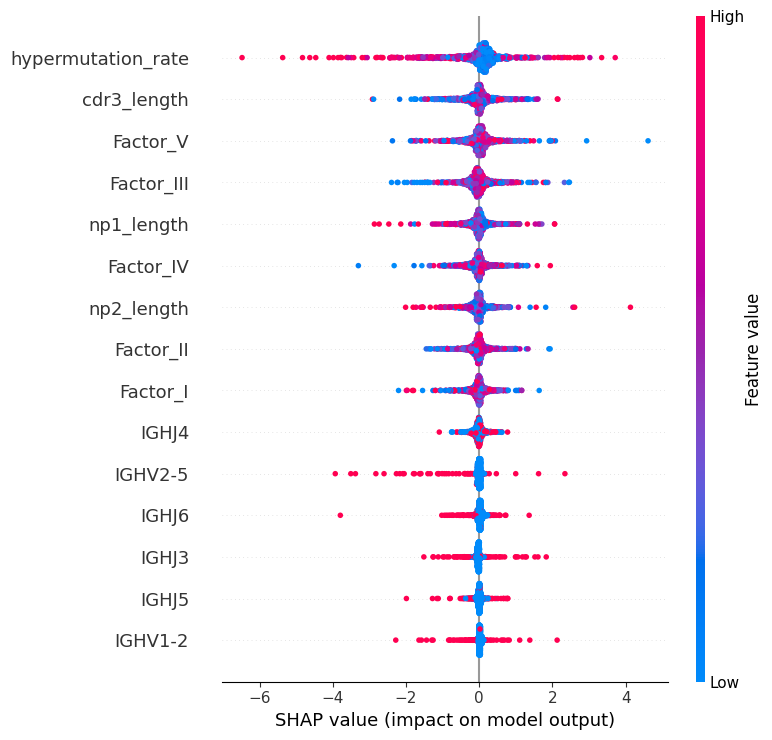

<Figure size 640x480 with 0 Axes>

In [30]:
model.eval()
model.cpu()

# Use SHAP's DeepExplainer
explainer = shap.DeepExplainer(model, background)

# Compute SHAP values
shap_values = explainer.shap_values(test_samples)

# shap_values will be a list; extract the first item for binary classification
shap_values = shap_values.squeeze()  # shape: (N, num_features)

# Plot the summary with correct feature names
shap.summary_plot(shap_values,
                  test_samples,
                  feature_names=X_test_scaled.columns,
                  max_display=15)  # Show all features

plt.savefig("shap_summary_plot.png", dpi=300, bbox_inches='tight')

In [ ]:
# After running DeepExplainer and getting shap_values
expected_value = explainer.expected_value[0]  # For binary classification
features_display = X_test_scaled.columns      # Or test_samples if you want values

# If test_samples is a tensor, convert to numpy
test_samples_np = test_samples.numpy()

'\n# Plot the decision plot\nshap.decision_plot(\n    expected_value,\n    shap_values,\n    test_samples_np,\n    feature_names=list(features_display)\n'

In [13]:
explanation = explainer(test_samples)

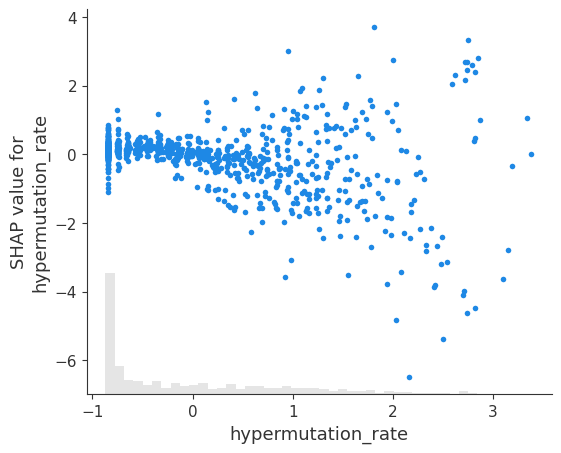

<Figure size 640x480 with 0 Axes>

In [14]:
# Suppose you have your original feature names
feature_names = X_test_scaled.columns  # if it's a pandas DataFrame

# Re-attach feature names to your Explanation object
explanation.feature_names = feature_names.tolist()
if not isinstance(explanation.data, np.ndarray):
    explanation.data = explanation.data.cpu().numpy()

# Now plot for the first feature (index 0)
shap.plots.scatter(explanation[:, "hypermutation_rate", 0])
plt.savefig("hypermutation_rate.png", dpi=300, bbox_inches='tight')

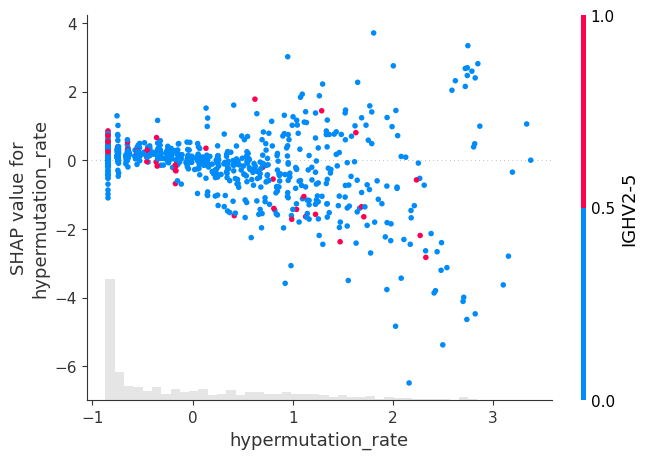

In [15]:
shap.plots.scatter(explanation[:, "hypermutation_rate", 0], color=explanation[:,:,0])

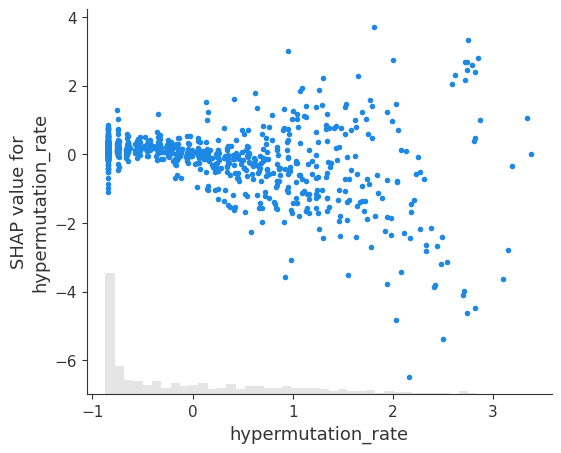

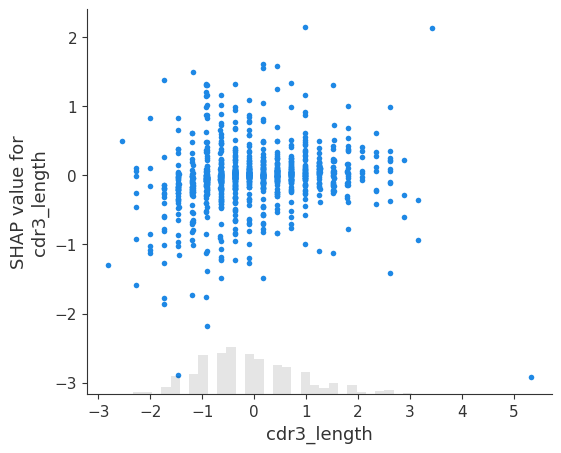

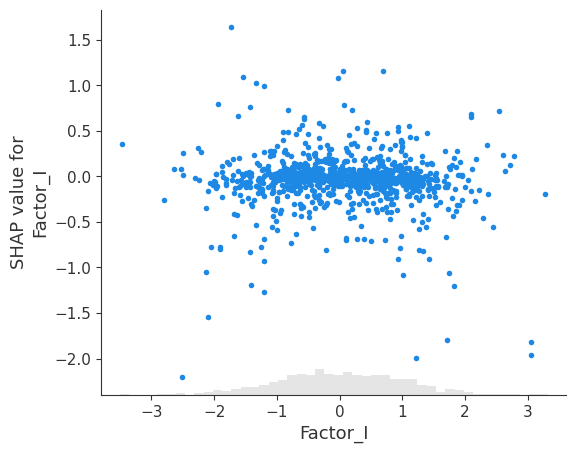

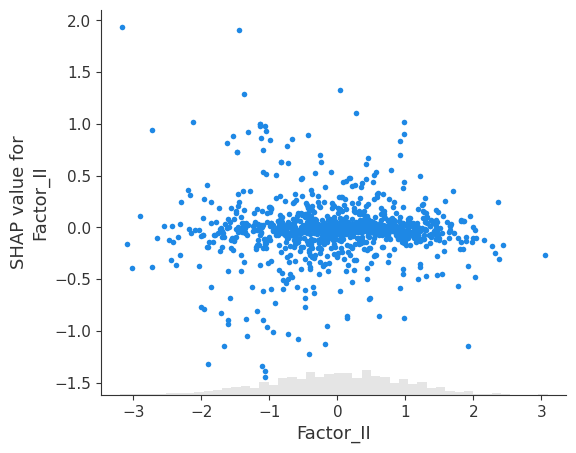

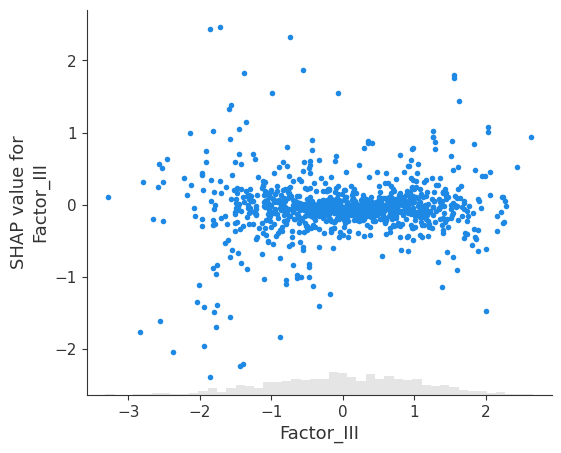

In [18]:
for i in explanation.feature_names[0:5]:
    shap.plots.scatter(explanation[:, i, 0])

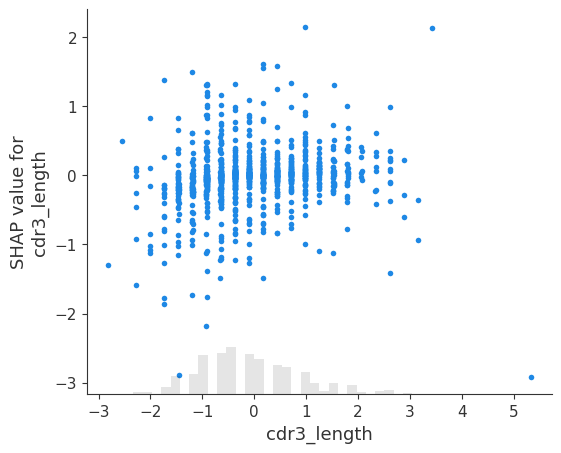

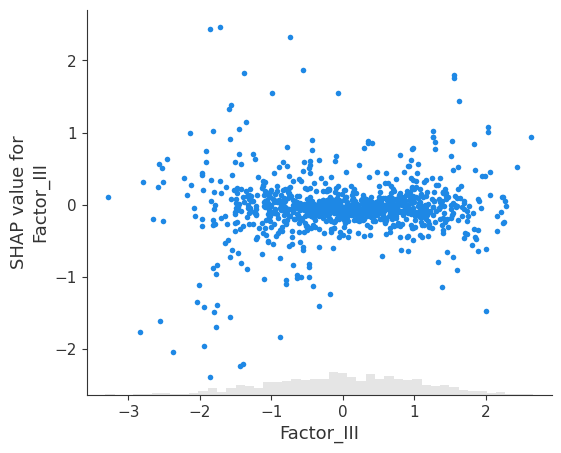

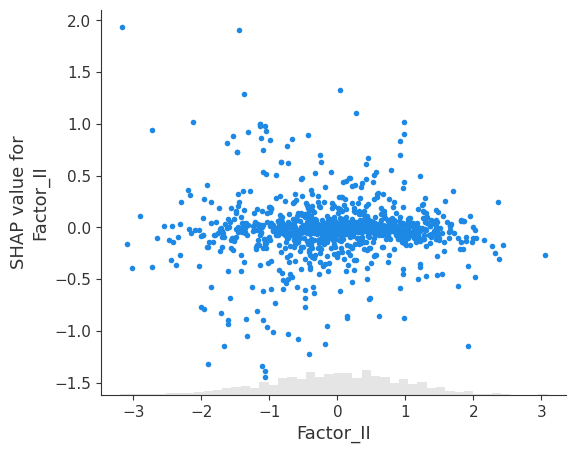

In [19]:
shap.plots.scatter(explanation[:, "cdr3_length", 0])
shap.plots.scatter(explanation[:, "Factor_III", 0])
shap.plots.scatter(explanation[:, "Factor_II", 0])

## 1.2 Deep explainer with inverse scaled values

In [6]:
# Background data using 100 random samples from training set
torch.manual_seed(42)

# Suppose X is your tensor of shape (N, d)
N_train = X_train_tensor.size(0)

# Generate a random permutation of indices [0, 1, …, N-1]
perm_train = torch.randperm(N_train)

# Take the first X indices from the shuffled order
selected_idx = perm_train[:100]

# Index into X to get your random subset
background = X_train_tensor[selected_idx]

In [7]:
# SHAP samples using 1000 random samples from testing set

torch.manual_seed(42)

# Suppose X is your tensor of shape (N, d)
N_test = X_test_tensor.size(0)

# Generate a random permutation of indices [0, 1, …, N-1]
perm_test = torch.randperm(N_test)

# Take the first X indices from the shuffled order
selected_idx = perm_test[:1000]

# Index into X to get your random subset
test_samples = X_test_tensor[selected_idx]

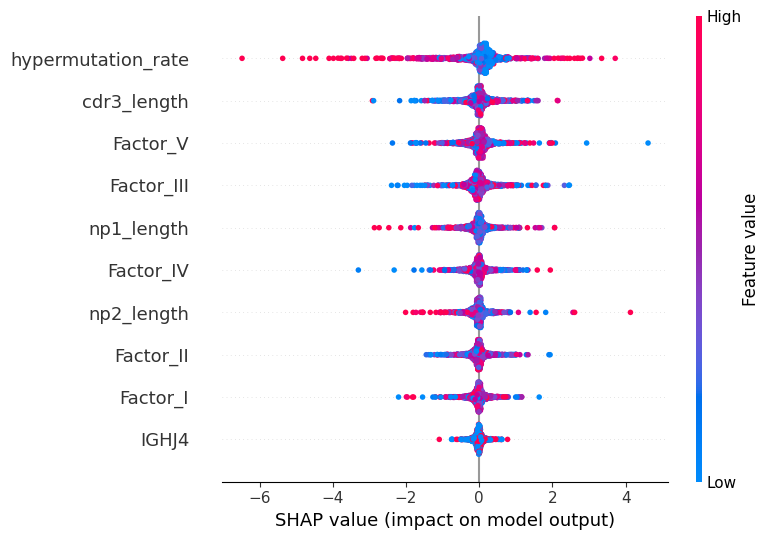

In [8]:
model.eval()
model.cpu()

# Use SHAP's DeepExplainer
explainer = shap.DeepExplainer(model, background)

# Compute SHAP values
shap_values = explainer.shap_values(test_samples)

# shap_values will be a list; extract the first item for binary classification
shap_values = shap_values.squeeze()  # shape: (N, num_features)

test_samples_np = test_samples.numpy()
first_9 = test_samples_np[:, :9]
rest = test_samples_np[:, 9:]

# Only inverse transform the first 9 features
first_9_original = scaler.inverse_transform(first_9)

# Concatenate back with the rest of the features
test_sample_inverse = np.concatenate([first_9_original, rest], axis=1)

# Plot the summary with correct feature names
shap.summary_plot(shap_values,
                  test_sample_inverse,
                  feature_names=X_test_scaled.columns,
                  max_display=10,
                  show=False )  # Show all features

plt.savefig("shap_summary_plot_inverse.png", dpi=300, bbox_inches='tight')

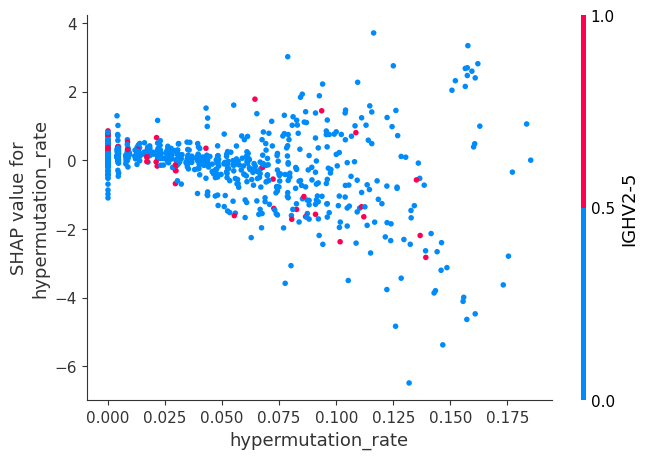

In [9]:
shap.dependence_plot(
    "hypermutation_rate",           
    shap_values,            
    test_sample_inverse,          
    feature_names=X_test_scaled.columns,
    show=False 
)
plt.savefig("shap_dependence_hypermutation_rate_inverse.png", dpi=300, bbox_inches='tight')
plt.show()

In [13]:
explanation = explainer(test_samples)

# Suppose you have your original feature names
feature_names = X_test_scaled.columns  # if it's a pandas DataFrame

# Re-attach feature names to your Explanation object
explanation.feature_names = feature_names.tolist()
if not isinstance(explanation.data, np.ndarray):
    explanation.data = explanation.data.cpu().numpy()

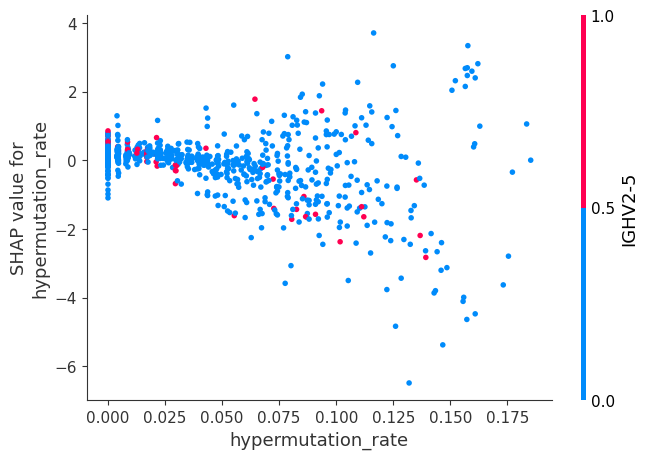

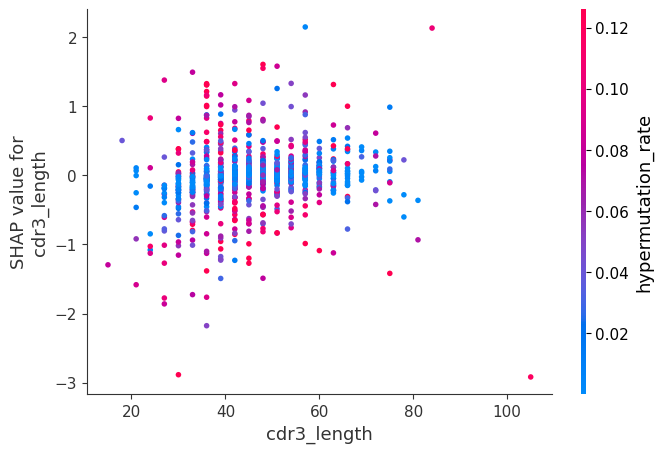

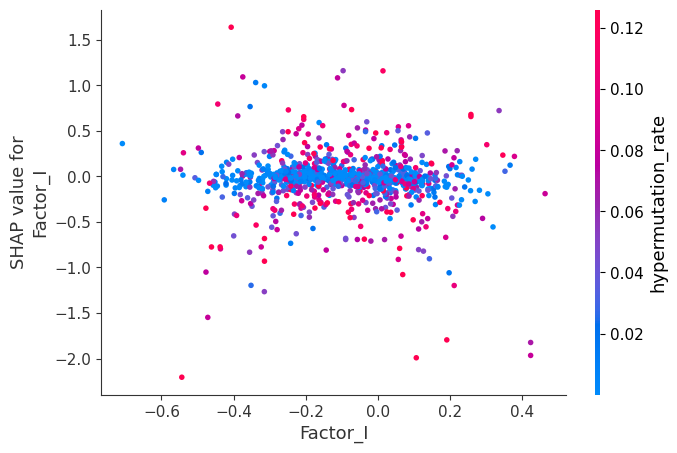

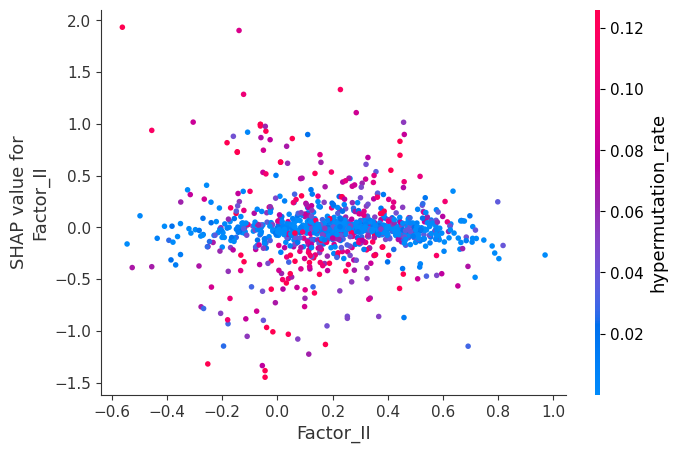

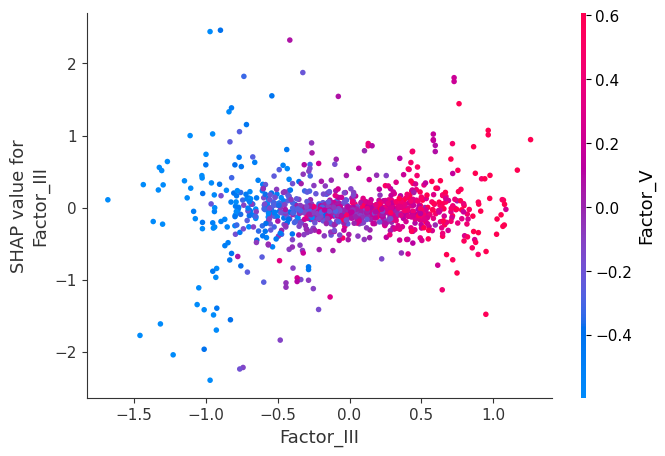

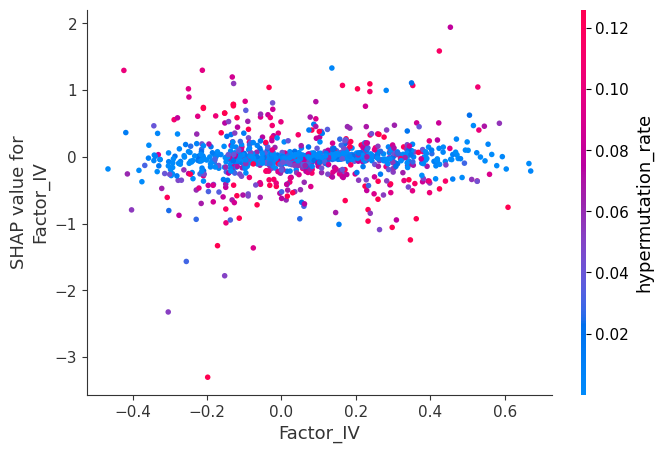

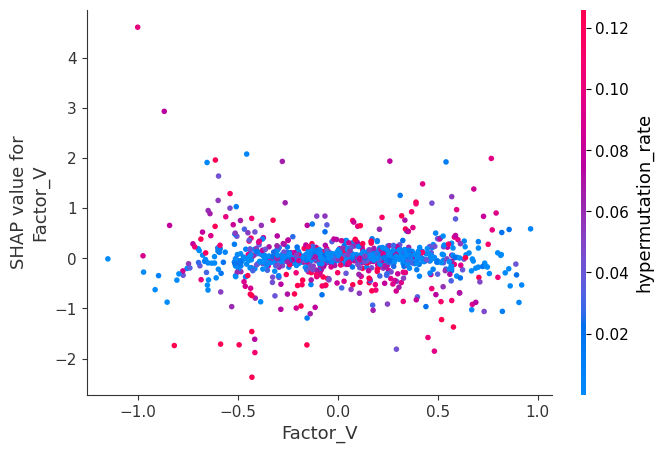

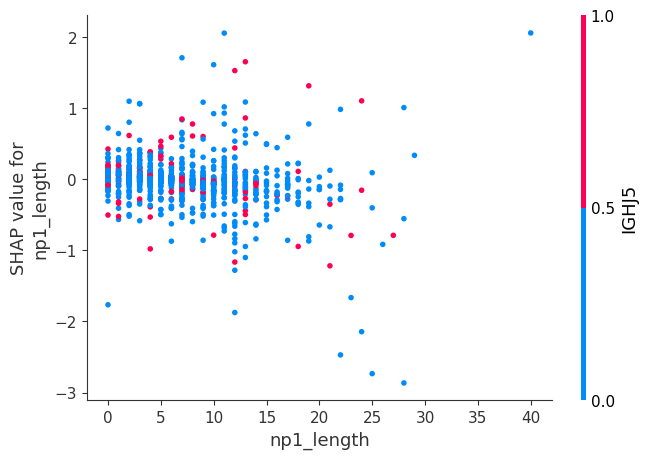

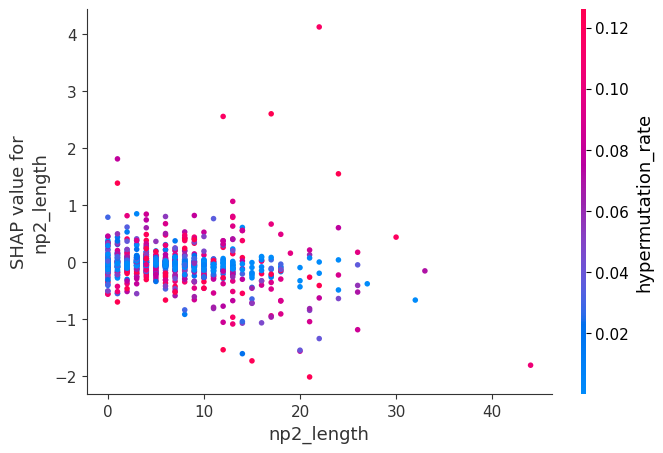

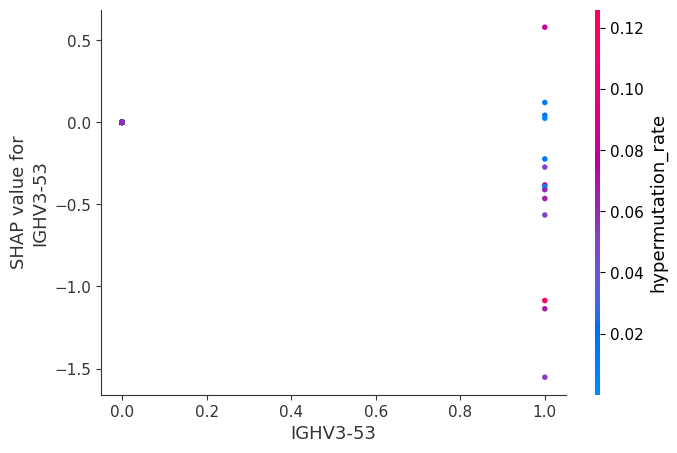

In [14]:
for features in explanation.feature_names[0:10]:
    shap.dependence_plot(
    features,         
    shap_values,       
    test_sample_inverse,        
    feature_names=X_test_scaled.columns,
    show=False 
    )
    plt.savefig(f"shap_dependence_{features}_inverse.png", dpi=300, bbox_inches='tight')
    plt.show()